In [1]:
!pip install -q transformers

In [2]:
!pip install -q datasets jiwer

## Prepare data

We first download the data. Here, I'm just using the IAM test set, as this was released by the TrOCR authors in the unilm repository. It can be downloaded from [this page](https://github.com/microsoft/unilm/tree/master/trocr).

Let's make a [regular PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). We first create a Pandas dataframe with 2 columns. Each row consists of the file name of an image, and the corresponding text.

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, Seq2SeqTrainer, Seq2SeqTrainingArguments, AutoTokenizer, default_data_collator
from datasets import load_metric
import logging


In [22]:
config = {
    "label_path": '/teamspace/studios/this_studio/vn_handwritten_images/labels.json',
    "image_folder": '/teamspace/studios/this_studio/vn_handwritten_images/data',
    "model_name": "microsoft/trocr-base-handwritten",
    "tokenizer_name": "vinai/phobert-base-v2",
    "output_dir": "./",
    "train_test_split_ratio": 0.2,
    "batch_size": 16,  # Tăng kích thước batch nếu VRAM cho phép
    "learning_rate": 1e-5,
    "num_train_epochs": 50,
    "logging_steps": 4,
    "save_steps": 2000,
    "eval_steps": 400,
    "gradient_accumulation_steps": 1,  # Điều chỉnh nếu cần
    "max_length": 64,
    "early_stopping": True,
    "no_repeat_ngram_size": 3,
    "length_penalty": 2.0,
    "num_beams": 4,
    "max_target_length": 128
}


In [23]:
logging.basicConfig(level=logging.INFO)

In [24]:
try:
    with open(config["label_path"], 'r') as file:
        labels = json.load(file)
    df = pd.DataFrame(list(labels.items()), columns=['file_name', 'label'])
except Exception as e:
    logging.error(f"Lỗi khi tải nhãn: {e}")

# Xử lý dữ liệu
df['file_name'] = df['file_name'].apply(lambda x: x + 'g' if x.endswith('jp') else x)

We split up the data into training + testing, using sklearn's `train_test_split` function.

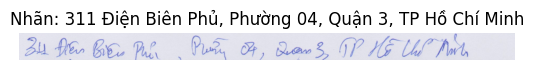

In [25]:
image_files = [os.path.join(config["image_folder"], f) for f in os.listdir(config["image_folder"]) if os.path.isfile(os.path.join(config["image_folder"], f))]
random_image_file = np.random.choice(image_files)
image_name = os.path.basename(random_image_file)
label_row = df[df['file_name'] == image_name]
label_text = label_row['label'].values[0] if not label_row.empty else 'Nhãn không tìm thấy'

img = mpimg.imread(random_image_file)
plt.imshow(img)
plt.title(f"Nhãn: {label_text}")
plt.axis('off')
plt.show()


In [26]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

Each element of the dataset should return 2 things:
* `pixel_values`, which serve as input to the model.
* `labels`, which are the `input_ids` of the corresponding text in the image.

We use `TrOCRProcessor` to prepare the data for the model. `TrOCRProcessor` is actually just a wrapper around a `ViTFeatureExtractor` (which can be used to resize + normalize images) and a `RobertaTokenizer` (which can be used to encode and decode text into/from `input_ids`).

In [27]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class VnHandwrittenImagesDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        # Check if 'text' is the correct column name, or if it should be something else, e.g., 'transcription'
        text = self.df['label'][idx] # Replace 'transcription' with the actual column name if it's different
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + '/' + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

Let's initialize the training and evaluation datasets:

In [28]:
from transformers import TrOCRProcessor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = TrOCRProcessor.from_pretrained(config["model_name"])
model = VisionEncoderDecoderModel.from_pretrained(config["model_name"])
tokenizer = AutoTokenizer.from_pretrained(config["tokenizer_name"])
model.to(device)
train_dataset = VnHandwrittenImagesDataset(root_dir=config["image_folder"], df=train_df, processor=processor, max_target_length=config["max_target_length"])
eval_dataset = VnHandwrittenImagesDataset(root_dir=config["image_folder"], df=test_df, processor=processor, max_target_length=config["max_target_length"])


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 1470
Number of validation examples: 368


Let's verify an example from the training dataset:

In [30]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=4)

## Train a model

Here, we initialize the TrOCR model from its pretrained weights. Note that the weights of the language modeling head are already initialized from pre-training, as the model was already trained to generate text during its pre-training stage. Refer to the paper for details.

Importantly, we need to set a couple of attributes, namely:
* the attributes required for creating the `decoder_input_ids` from the `labels` (the model will automatically create the `decoder_input_ids` by shifting the `labels` one position to the right and prepending the `decoder_start_token_id`, as well as replacing ids which are -100 by the pad_token_id)
* the vocabulary size of the model (for the language modeling head on top of the decoder)
* beam-search related parameters which are used when generating text.

In [31]:
# import package AutoTokenizer
from transformers import AutoTokenizer



model.config.decoder.vocab_size = len(tokenizer)
model.decoder.resize_token_embeddings(len(tokenizer))

model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.eos_token_id = tokenizer.sep_token_id

model.config.max_length = config["max_length"]
model.config.early_stopping = config["early_stopping"]
model.config.no_repeat_ngram_size = config["no_repeat_ngram_size"]
model.config.length_penalty = config["length_penalty"]
model.config.num_beams = config["num_beams"]


We will evaluate the model on the Character Error Rate (CER), which is available in HuggingFace Datasets (see [here](https://huggingface.co/metrics/cer)).

In [32]:
%pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [33]:
import evaluate
cer_metric = evaluate.load("cer")

In [34]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [35]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=config["batch_size"],
    per_device_eval_batch_size=config["batch_size"],
    fp16=True,
    output_dir=config["output_dir"],
    logging_steps=config["logging_steps"],
    save_steps=config["save_steps"],
    eval_steps=config["eval_steps"],
    gradient_accumulation_steps=config["gradient_accumulation_steps"],
    learning_rate=config["learning_rate"],
    num_train_epochs=config["num_train_epochs"],
)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [36]:
from transformers import default_data_collator
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.image_processor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

Step,Training Loss,Validation Loss,Cer
400,0.088000,0.230644,0.077707
800,0.053600,0.201272,0.073229
1200,0.006400,0.218866,0.069131
1600,0.004000,0.220150,0.064510
2000,0.002700,0.220505,0.066606
2400,0.000900,0.221266,0.065320


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/generation/utils.py:1375: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


KeyboardInterrupt: 

## Inference

Note that after training, you can easily load the model using the .`from_pretrained(output_dir)` method.

For inference on new images, I refer to my inference notebook, that can also be found in my [Transformers Tutorials repository](https://github.com/NielsRogge/Transformers-Tutorials) on Github.

In [37]:
def predict_text(image):
    pixel_values = processor(image, return_tensors="pt").pixel_values
    # Move pixel_values to the same device as the model
    pixel_values = pixel_values.to(model.device)
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

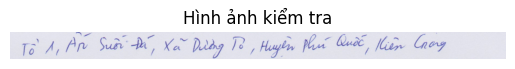

Nhãn thực tế: Tổ 1, ấp Suối Đá, Xã Dương Tơ, Huyện Phú Quốc, Kiên Giang
Văn bản dự đoán: Tổ 1, Đền Sướn Đà, Xã Dương Tô, Huyện Nhú Quốc, Kiên Giang


In [41]:
image_folder = config["image_folder"]
random_index = np.random.randint(0, len(test_df))
test_image_name = test_df.iloc[random_index]['file_name']
test_image_label = test_df.iloc[random_index]['label']
test_image_path = os.path.join(image_folder, test_image_name)

# Đọc và hiển thị hình ảnh
image = Image.open(test_image_path).convert("RGB")
plt.imshow(image)
plt.title("Hình ảnh kiểm tra")
plt.axis('off')
plt.show()
import numpy as np
from PIL import Image

# You no longer need to resize the image here
# Dự đoán văn bản từ hình ảnh
predicted_text = predict_text(image)

# In kết quả
print(f"Nhãn thực tế: {test_image_label}")
print(f"Văn bản dự đoán: {predicted_text}")

In [47]:
!


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [48]:
!7z a -mx=9 /content/model.safetensors.7z /teamspace/studios/this_studio/checkpoint-2000


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C.UTF-8,Utf16=on,HugeFiles=on,64 bits,16 CPUs AMD EPYC 7R13 Processor (A00F11),ASM,AES-NI)

Scanning the drive:
  0M Scan  /teamspace/studios/this_studi                                        1 folder, 9 files, 4171699290 bytes (3979 MiB)

Creating archive: /content/model.safetensors.7z

Items to compress: 10

  0%

    0% 2 + checkpoint-2000/model.safetenso                                          0% 3 + checkpoint-2000/optimizer.p                                      1% 3 + checkpoint-2000/optimizer.p                                      2% 3 + checkpoint-2000/optimizer.p                                      3% 3 + checkpoint-2000/optimizer.p                                      4% 3 + checkpoint-2000/optimizer.p                                      5% 3 + checkpoint-2000/optimizer.p                                      6% 3 + checkpoint-2000/optimizer.p                                      7% 3 + checkpoint-2000/optimizer.p                                      8% 3 + checkpoint-2000/optimizer.p                                      9% 3 + checkpoint-2000/optimizer.p                                     10% 3 + checkpoint-2000/optimizer.p                                     11% 3 + checkpoint-2000/optimizer.p                                     12% 3 + checkpoint-2000/optimizer.p                  